In [1]:
import csv
import numpy as np
%matplotlib inline

# I. Dataset

In [2]:
data_filename = "data/ionosphere.data"

In [3]:
# Size taken from the dataset and is known already
X = np.zeros((351, 34), dtype='float')
y = np.zeros((351,), dtype='bool')

with open(data_filename, 'r') as input_file:
    reader = csv.reader(input_file)
    for i, row in enumerate(reader):
        # Get the data, converting each item to a float
        data = [float(datum) for datum in row[:-1]]
        # Set the appropriate row in our dataset
        X[i] = data
        # 1 if the class is 'g', 0 otherwise
        y[i] = row[-1] == 'g'

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 263 samples in the training dataset
There are 88 samples in the testing dataset
Each sample has 34 features


# II. KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# By default, KNeightborsClassifier set n_neighbors = 5
estimator = KNeighborsClassifier()

In [6]:
estimator.fit(X_train, y_train)

KNeighborsClassifier()

In [7]:
y_predicted = estimator.predict(X_test)
accuracy = np.mean(y_test == y_predicted) * 100
print("The accuracy is {0:.1f}%".format(accuracy))

The accuracy is 86.4%


This model scores 86.4 percent accuracy, which is impressive for a default algorithm and just a few lines of code! Most scikit-learn default parameters are chosen deliberately to work well with a range of datasets.

# III. Cross-fold Validation

In [8]:
from sklearn.model_selection import cross_val_score

In [9]:
scores = cross_val_score(estimator, X, y, scoring='accuracy')
average_accuracy = np.mean(scores) * 100
print("The average accuracy is {0:.1f}%".format(average_accuracy))

The average accuracy is 82.6%


It's natural for variation in results when performing data mining due to variation in how the folds are created and randomness inherent in some classification algos.

It's a good idea to rerun experiments multiple times to get a sense of the average result and the spread of the results (the mean and stadard deviation) across all experiments.

# IV. Parameters tuning

In [10]:
avg_scores = []
all_scores = []
parameter_values = list(range(1, 21))  # Including 20
for n_neighbors in parameter_values:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, X, y, scoring='accuracy')
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)

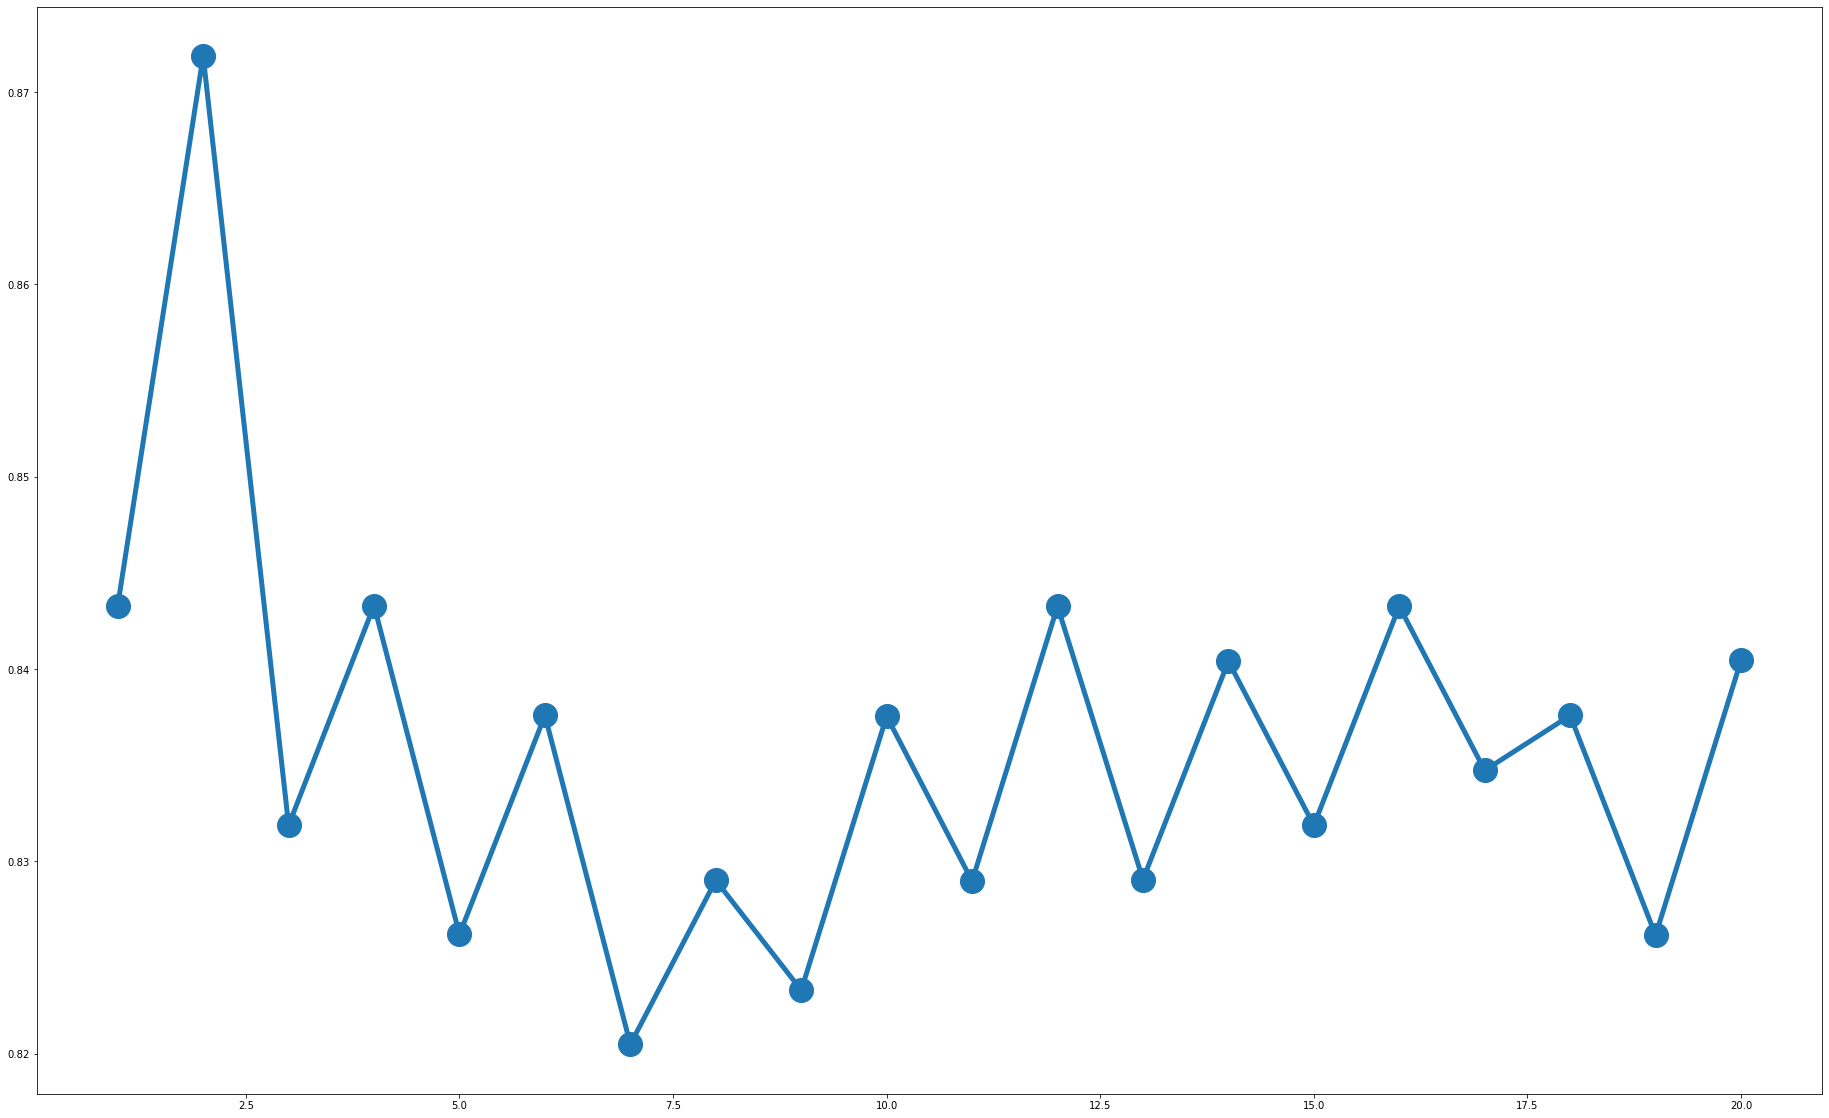

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,20))
plt.plot(parameter_values, avg_scores, '-o', linewidth=5, markersize=24)

The plot shows a decreasing trend as the number of neighbors increases.

Since there's a lot variance, you can compensate be update the code to run 100 tests per value of `n_neighbors`

# V. Pre-processing
### Experiment

In [12]:
# Copy the array so we don't alter the original dataset
X_broken = np.array(X)

# Break the dataset by dividing every second feature by 10 (for experimenting purpose)
X_broken[:,::2] /= 10

In theory, this should not have a great effect on the result since all the values of these features are still relatively the same. The major issue is that the scale has changed and the odd features are now *larger* than the even features.

Let see the actual effect

In [13]:
estimator = KNeighborsClassifier()
original_scores = cross_val_score(estimator, X, y,
  scoring='accuracy')
print("The original average accuracy for is {0:.1f}%".format(np.mean(original_scores) * 100))
broken_scores = cross_val_score(estimator, X_broken, y,
  scoring='accuracy')
print("The 'broken' average accuracy for is {0:.1f}%".format(np.mean(broken_scores) * 100))

The original average accuracy for is 82.6%
The 'broken' average accuracy for is 73.8%


### Feature-based normalization

In [14]:
from sklearn.preprocessing import MinMaxScaler

`MinMaxScaler` takes each feature and scales it to the range 0 - 1. It replaces the min value with *0*, the max with *1* and the other vlaues somewhere in between based on a linear mapping.

In [15]:
X_transformed = MinMaxScaler().fit_transform(X)

In [16]:
X_transformed = MinMaxScaler().fit_transform(X_broken)
estimator = KNeighborsClassifier()
transformed_scores = cross_val_score(estimator, X_transformed, y, 
  scoring='accuracy')
print("The average accuracy for is {0:.1f}%".format(np.mean(transformed_scores) * 100))

The average accuracy for is 82.9%


The `MinMaxScaler` resulted in features of the same scale, meaning that no features overpowered others by simply being bigger values.

# VI. Simplify the workflow with Pipeline
> Pipelines store the steps in your data mining workflow. They can take your raw data in, perform all the necessary transformations, and then create a prediction. 

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
scaling_pipeline = Pipeline([('scale', MinMaxScaler()),
                             ('predict', KNeighborsClassifier())])
scores = cross_val_score(scaling_pipeline, X_broken, y, scoring='accuracy')
print("The pipeline scored an average accuracy for is {0:.1f}%".format(np.mean(transformed_scores) * 100))

The pipeline scored an average accuracy for is 82.9%


In [19]:
# Test out the pipeline with StandardScaler
from sklearn.preprocessing import StandardScaler
scaling_pipeline = Pipeline([('scale', StandardScaler()),
                             ('predict', KNeighborsClassifier())])
scores = cross_val_score(scaling_pipeline, X_broken, y, scoring='accuracy')
print("The pipeline scored an average accuracy for is {0:.1f}%".format(np.mean(transformed_scores) * 100))

The pipeline scored an average accuracy for is 82.9%


In [20]:
# Test out the pipeline with Normalizer
from sklearn.preprocessing import Normalizer
scaling_pipeline = Pipeline([('scale', StandardScaler()),
                             ('predict', KNeighborsClassifier())])
scores = cross_val_score(scaling_pipeline, X_broken, y, scoring='accuracy')
print("The pipeline scored an average accuracy for is {0:.1f}%".format(np.mean(transformed_scores) * 100))

The pipeline scored an average accuracy for is 82.9%
